A Brief Intro to Nanoreactor Python Package
====

This is a short guide on how to use Nanoreactor functionalities in interactive python enviroments.  Jupyter notebook is used here, but everything also apply to `ipython`, jupyter lab, and for the most part the normal `python` interactive.  This documentation is generated with `jupyter notebook`, but the content should apply to any python 2 environment unless otherwise specified.

The following examples are all run from my laptop, which should apply to any other environment with nanoreactor package installed.

Getting component documentations
----
Classes, functions and methods are documented inline.  There are a few ways to retreive these documentations.

- the `help` command.   Python's `help` command can be used on any nanoreactor package, module, class, object, method or functions to retrieve their documentations. For example

In [1]:
from nanoreactor import ReactionDatabase
help(ReactionDatabase)

Help on class ReactionDatabase in module nanoreactor.parsing.reaction_database:

class ReactionDatabase(__builtin__.object)
 |  Nanoreactor reaction database.  Maintains database connection through a
 |  MongoDB client, and provides serialization and deserialization of object-
 |  relational mappings of reactions and species, and aggregation to unique
 |  reaction and species collections.
 |  
 |  Also handles indexing, but note that any db or indexing behavior can be changed
 |  directly by accessing the MongoDB connection `mongodb`, or the client `.client`
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name, host='fire-05-30', port=27017, create=False)
 |      Establish MongoDB client connection to a database.
 |      
 |      Args:
 |          name:   Name of the database
 |          host:   Host name of the DB server.
 |          port:   Port number of the DB service
 |          create: Whether to create the DB if not already exist.  If create is `False`
 |                 

Note that the same can be obtained outside of python environment via `pydoc`.  For example, the above documentations can be obtained through the following command in shell:
```bash
pydoc nanoreactor.ReactionDatabase
```
- In `jupyter` and `ipython` you can press tab after you place a dot to see the members of an object.  You can also type `?` after an object then press enter to see its documentation in a pop up.
- In `jupyter` you can press `shift`+`tab` after you have typed an object's name to see its signature, i.e. arguments and their descritions etc.


Connecting to the database
----

A connection to nanoreactor databases can be obtained by creating a `ReactionDatabase` object.  

Before running the following example, an ssh tunnel was created to allow access to `fire` from my laptop using the following command:

```bash
ssh -f -N -T -L 31945:localhost:27017 virtualzx@fire-6-0-ext.slac.stanford.edu
```

You do not need this tunnel if you are on `fire`. Instead, directly connect to `fire-05-30` to access the database.

In [2]:
db=ReactionDatabase('xz_Furoate',host='localhost', port=31945)

Querying reactions and species
----
There are a number of methods that can be used to query reactions and species.
- Use the `find_reaction` method to find reaction paths.  This method queries the database and returns a list of `Reaction` objects that correspond to reaction paths that satisfies the query conditions.  See `MongoDB` documentation for the query language specifications.

In [3]:
results= list(db.find_reactions({'info.natoms': 10, 'info.status': 'intermediate'}, max_results=5))
path0 = results[0]
print path0
print type(path0)

<Reaction [H][C]1[C][O][C]([C]([O])[O])[C]1[H]{-2,1} => [H][C]1[C][O][C][C]1[H]{-2,1} + [O][C][O]{0,1} (15 frames)>
<class 'nanoreactor.parsing.reaction.Reaction'>


The `Reaction` objects contain all information of a specific path, for example its atoms, coordinates, labels, charges, etc.  See its documentation for more info.

In [4]:
help(path0)

Help on Reaction in module nanoreactor.parsing.reaction object:

class Reaction(nanoreactor.core.history.History)
 |  Defines a reaction.  This uses the data storage capacity of History,
 |  and adds to it methods to extract reaction from a trajectory, a saved
 |  trajectory collection, or direct storage/query with the reaction collection.
 |  
 |  Metadata describing the reaction is saved in the info field.
 |  
 |  Method resolution order:
 |      Reaction
 |      nanoreactor.core.history.History
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __getattr__(self, item)
 |      Retrieve attribute from the metadata `info` field if available.
 |  
 |  __init__(self, mol=None, info=None, frames=(), _id=None, fields=None, locked=False, representation=None, *args, **kwargs)
 |      Create a Reaction object from a metadata dictionary and data in each
 |      frame.
 |      Args:
 |          mol:     Molecule object.  Optional as long as info contains the needed info.
 |    

Reaction paths can be saved to xyz format using the `save_xyz` method.

In [5]:
path0.save_xyz('path.xyz')

- Use the `find_species` method to find species.  This method queries the database and returns a list of `Molecule` objects that correspond to molecular geometries that satisfy the query conditions.  Similarly one can use the `save_xyz` method to save the molecular geometry to an xyz file

In [6]:
results= list(db.find_species({'natoms': {'$lt': 5}, 'charge': 0}, max_results=5))
mol = results[0]
print mol
print mol.status
print type(mol)
mol.save_xyz('CO2.xyz')

<Molecule CO2 charge:0 mult:1 >
raw
<class 'nanoreactor.core.molecule.Molecule'>


- It is sometimes more convenient to query for an `UniqueReaction` or `UniqueSpecies`, which are classes of reaction paths and molecular geometries that are recognized as belonging to the same chemical entity by the program.  These are metadata generated by the reaction database from the raw data.  One can query these documents through the `mongodb` connection. These documents are in the form of dictionaries.

In [7]:
from pprint import pprint
doc = db.mongodb.UniqueReaction.find_one({'natoms': 12, 'formation_barrier': {'$lt': 50}})
pprint(doc)

{u'_id': ObjectId('5c61f9049a9b86796318aeec'),
 u'atoms': [u'H',
            u'C',
            u'O',
            u'O',
            u'O',
            u'C',
            u'O',
            u'O',
            u'O',
            u'C',
            u'O',
            u'O'],
 u'backward_barrier': 25.742157594673976,
 u'bodies': 2,
 u'charge': -3,
 u'count': {u'approximate': 2, u'inactive': 19, u'raw': 2, u'warm': 1},
 u'formation_barrier': 24.995895826484357,
 u'forward_barrier': 1.5282002498052154,
 u'has_thermo': True,
 u'label': u'[H][O][C]([O])[O][C]([O])[O]{-1,1} + [O][C]([O])[O]{-2,1} => [H][O][C]([O])[O]{-1,1} + [O][C]([O])[O][C]([O])[O]{-2,1}',
 u'members': [ObjectId('5b5e29cf0d81c87e8104ff6b'),
              ObjectId('5b644d7df057552cfb39e682'),
              ObjectId('5b644d7ef057552cfb39e687'),
              ObjectId('5b64da7f8390d045b8d6613c'),
              ObjectId('5b65ac860c563e25e59618d6'),
              ObjectId('5b67fdec8390d02f51760889'),
              ObjectId('5b6e4d3e8390d06

One can also directly retrieve an `UniqueReaction` or `UniqueSpecies` documents using its label using `get_reaction` and 
`get_species` method of the `ReactionDatabase` class.  Here we verify that we are getting the same document

In [8]:
doc2 = db.get_reaction(doc['label'])
doc2 == doc

True

One can also directly retrieve a reaction path or molecular geometry using its `ObjectId`, for example, as shown in `members` field and several other places.

In [9]:
r = db.get_reaction('5c6274341791d0c62e5749ff')
print r.status

done


Analysis tools
----
Various analysis tools are available in the `analysis` package.  We need more of them.

- To plot the energy profile of a reaction path, one can use the plotting module. (Requires `matplotlib` to be installed)

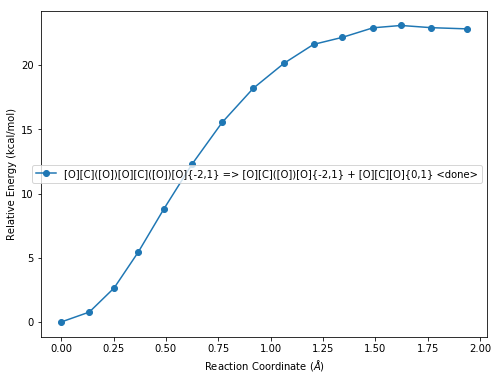

In [11]:
from nanoreactor.analysis import plotting
with plotting.session():
    plotting.plot_reaction(r)

The `session` context manager can be used to plot multiple paths in the same figure. Currently, all plotting funcitonalities are ugly and improvements are welcome.

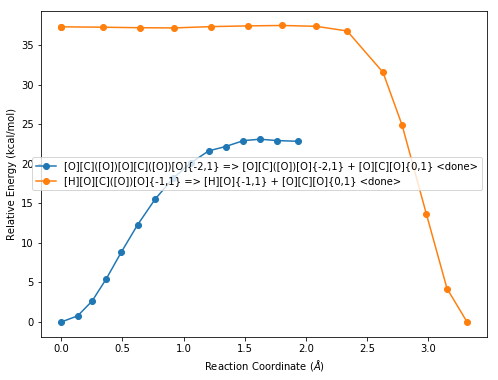

In [12]:
r2=db.get_reaction('5c626b731791d0c62e5749fe')
with plotting.session():
    plotting.plot_reaction(r)
    plotting.plot_reaction(r2)

- Use `report` tools to see a brief report of a reaction database.   It may take a minute to generate summaries for large databases.

In [14]:
from nanoreactor.analysis.report import report
report(db, max_reactions=20, max_species=10, print_level=2)

=== Reaction database < xz_Furoate > ===
Number of registered trajectories: 161
Number of unique species: 1278
   <present>    [O][C]([O])[O][C]([O])[O]{-2,1}
    Formation barrier: 0.00 kcal/mol   Occurrences: 1206
    Latest instance: 5c61b6700fa7d04581fe3c1e   Status: intermediate
   <present>    [Cs]{1,1}
    Formation barrier: 0.00 kcal/mol   Occurrences: 182
    Latest instance: 5c54e9f60259556c020bae1f   Status: thermo
   <present>    [O][C][O]{0,1}
    Formation barrier: 0.00 kcal/mol   Occurrences: 2581
    Latest instance: 5c65d7548390d0f975be2025   Status: intermediate
   <present>    [H][C]1[O][C]([C]([O])[O])[C]([H])[C]1[H]{-1,1}
    Formation barrier: 0.00 kcal/mol   Occurrences: 660
    Latest instance: 5c6090c70fa7d077e05ce57e   Status: intermediate
   <present>    [O][C]([O])[O]{-2,1}
    Formation barrier: 0.00 kcal/mol   Occurrences: 2377
    Latest instance: 5c6571718390d0f975be2014   Status: intermediate
   <present>    [H][C]1[O][C]([C]([H])[C]1[H])[C]([O])([O][C]

- The `network_analysis` tool can be used to analyze reaction network and reaction/species feasibilities. 

Here, one can specify what species are initially available in the system. I.e., these are the species that are used to synthesize all the other species.  The method also marks each `UniqueReaction` and `UniqueSpecies` document with a tag and calculate their `formation_barrier` values. After the network analysis, `synthetic_network` tool is used to generate a synthesis path for a target species.  Note that this gives a **bipartite** graph with both reaction and species nodes.

In [15]:
from nanoreactor.analysis import network_analysis, synthetic_network
network_analysis(db, initial_species=['[O][C][O]{0,1}', '[O][C]([O])[O]{-2,1}',
                                      '[H][C]1[O][C]([C]([O])[O])[C]([H])[C]1[H]{-1,1}','[Cs]{1,1}'])
G=synthetic_network(db, '[H][C]1[C]([H])[C]([O][C]1[C]([O])[O])[C]([O])[O]{-2,1}')
for node in G.nodes():
    print node

[H][C]1[C][O][C]([C]([O])[O])[C]1[H]{-2,1}
[H][O][C]([O])[O]{-1,1}
[O][C][O]{0,1}
[H][C]1[C]([H])[C]([O][C]1[C]([O])[O])[C]([O])[O]{-2,1} => [H][C]1[C][O][C]([C]([O])[O])[C]1[H]{-2,1} + [O][C][O]{0,1}
[O][C]([O])[O]{-2,1}
[H][C]1[O][C]([C]([O])[O])[C]([H])[C]1[H]{-1,1}
[H][C]1[C][O][C]([C]([O])[O])[C]1[H]{-2,1} + [H][O][C]([O])[O]{-1,1} => [H][C]1[O][C]([C]([O])[O])[C]([H])[C]1[H]{-1,1} + [O][C]([O])[O]{-2,1}
[H][C]1[C]([H])[C]([O][C]1[C]([O])[O])[C]([O])[O]{-2,1}


`networkx` drawing functionalities can be used to create plots, along with `matplotlib`.

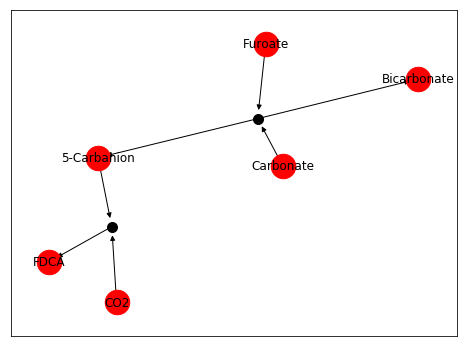

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
species = {
    '[O][C][O]{0,1}': 'CO2', '[O][C]([O])[O]{-2,1}': 'Carbonate',
    '[H][C]1[O][C]([C]([O])[O])[C]([H])[C]1[H]{-1,1}': 'Furoate',
    '[H][O][C]([O])[O]{-1,1}': 'Bicarbonate',
    '[H][C]1[C][O][C]([C]([O])[O])[C]1[H]{-2,1}': '5-Carbanion',
    '[H][C]1[C]([H])[C]([O][C]1[C]([O])[O])[C]([O])[O]{-2,1}': 'FDCA'
}  # Species names,  just to avoid the confusion of the SMILES strings
reactions=[node for node in G.nodes() if node not in species]

plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(G, pos, nodelist=species.keys(), node_size=600)   # Draw species nodes
nx.draw_networkx_nodes(G, pos, nodelist=reactions, node_size=100, node_color='k')        # Draw reaction nodes
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=species)
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False, top=False,
    left=False, right=False,
    labelbottom=False, labelleft=False)
plt.show()

Unfortunately, `networkx` plots are ugly.  For better visual one can export the graph and use external programs to plot it.